# Avito Data Exploration: Stage 0

In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import textblob
import goslate
import pprint

from collections import Counter

from sklearn.preprocessing import MultiLabelBinarizer

In [2]:
# Load parameters file
with open('setup_param.json', 'r') as handle:
    setup_params = json.load(handle)

In [3]:
parent_path = setup_params['parent_dir']
data_path = setup_params['data_dir']
scripts_path = setup_params['scripts_dir']
train_csv_path = setup_params['train_csv']
test_csv_path = setup_params['test_csv']

## Helper Fuctions

In [67]:
gs = goslate.Goslate()

In [5]:
def translate_to_english(text):
    decode_text = text.decode('UTF-8')
    try:
        translated_text = textblob.TextBlob(decode_text).translate(to='en')
        return str(translated_text)
    except:
        return decode_text

## Load Train and Test Data

In [6]:
train_df = pd.read_csv(train_csv_path)

In [7]:
test_df = pd.read_csv(test_csv_path)

In [8]:
print 'Shape of train_df:', train_df.shape
print 'Shape of test_df:', test_df.shape

Shape of train_df: (1503424, 18)
Shape of test_df: (508438, 17)


In [9]:
print train_df.columns.values

['item_id' 'user_id' 'region' 'city' 'parent_category_name'
 'category_name' 'param_1' 'param_2' 'param_3' 'title' 'description'
 'price' 'item_seq_number' 'activation_date' 'user_type' 'image'
 'image_top_1' 'deal_probability']


## Exploring "deal_probability" Field (Training Exclusive):

In [113]:
print 'Number of null values:', train_df.deal_probability.isnull().sum()

Number of null values: 0


In [114]:
deal_probs = train_df.deal_probability

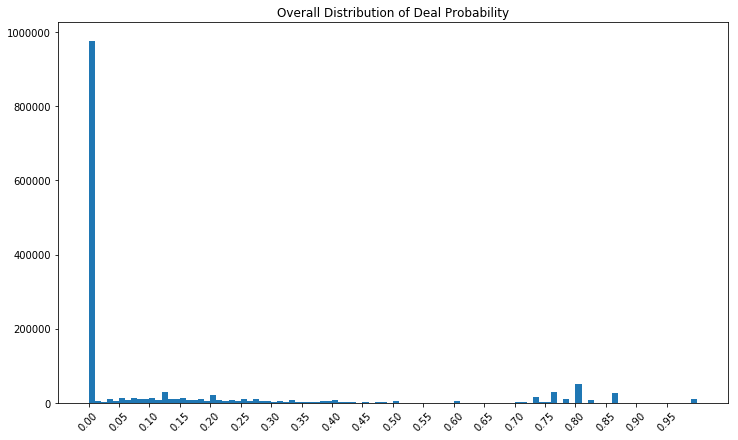

In [126]:
plt.figure(figsize=(12, 7))
deal_probs.hist(bins=100)
plt.title('Overall Distribution of Deal Probability')
plt.grid(False)
plt.xticks(np.arange(0, 1, step=0.05), rotation=45)
plt.show()

From the overall distribution plot above, it appears that the deal probability has a "long-tail" behavior. I will try to isolate the dense-end of the tail.

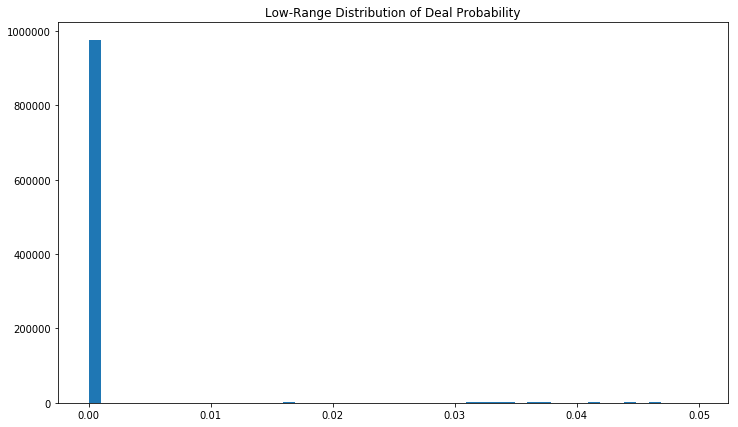

In [131]:
plt.figure(figsize=(12, 7))
deal_probs[deal_probs < 0.05].hist(bins=50)
plt.title('Low-Range Distribution of Deal Probability')
plt.grid(False)
plt.show()

In [152]:
probs_count = Counter(deal_probs.values)
sorted_counts = probs_count.most_common()
filtered_counts = list(filter(lambda x: x[1] > 150 and x[1] < 10000, sorted_counts))

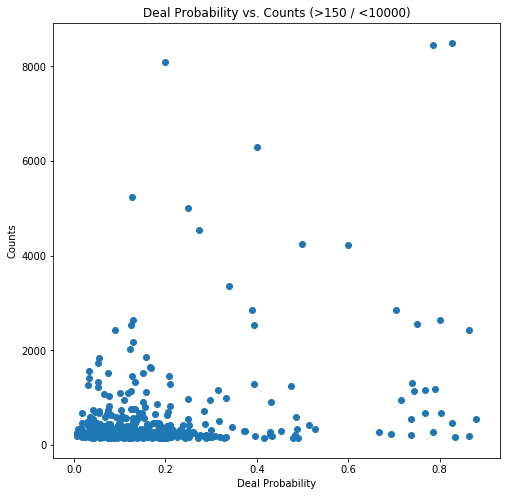

In [153]:
plt.figure(figsize=(8, 8))
plt.scatter([x[0] for x in filtered_counts], [x[1] for x in filtered_counts])
plt.title('Deal Probability vs. Counts (>150 / <10000)')
plt.xlabel('Deal Probability')
plt.ylabel('Counts')
plt.show()

## Exploring item_id and user_id Fields:

In [10]:
# Check for nans in train dataframe in these fields
train_df.loc[:][['item_id', 'user_id']].isnull().sum()

item_id    0
user_id    0
dtype: int64

In [11]:
# Check for nans in test dataframe in these fields
test_df.loc[:][['item_id', 'user_id']].isnull().sum()

item_id    0
user_id    0
dtype: int64

In [12]:
# Get overlap of item_id in train and test sets
train_item_id = np.array(list(set(train_df.item_id.values)))
test_item_id = np.array(list(set(test_df.item_id.values)))
item_intersect= np.intersect1d(train_item_id, test_item_id)
print 'Number of common entries in item_id field:', len(item_intersect)

Number of common entries in item_id field: 0


In [13]:
# Get overlap of user_id in train and test sets
train_user_id = np.array(list(set(train_df.user_id.values)))
test_user_id = np.array(list(set(test_df.user_id.values)))
user_intersect = np.intersect1d(train_user_id, test_user_id)
print 'Number of common entries in user_id field:', len(user_intersect)

Number of common entries in user_id field: 67929


In [14]:
print 'Ratio of shared elements in train set:', len(user_intersect)/float(len(train_user_id))
print 'Ratio of shared elements in test set:', len(user_intersect)/float(len(test_user_id))

Ratio of shared elements in train set: 0.0880172694161
Ratio of shared elements in test set: 0.22194015075


What this shows is that roughly 8.8% of the training set is repeated in the test set. This portion represents 22% of the test set (which is an appreciably large number).

## Exploring "region" Field:

In [15]:
# Check for nans in train dataframe in this field
train_df.region.isnull().sum()

0

In [16]:
# Check for nans in train dataframe in this field
test_df.region.isnull().sum()

0

In [17]:
train_regions_set = np.array(list(set(train_df.region.values)))
test_regions_set = np.array(list(set(test_df.region.values)))
regions_intersect = np.intersect1d(train_regions_set, test_regions_set)
print 'Number of regions in training set:', len(train_regions_set) 
print 'Number of regions in test set:', len(test_regions_set) 
print 'Number of shared regions between both sets:', len(regions_intersect) 

Number of regions in training set: 28
Number of regions in test set: 28
Number of shared regions between both sets: 28


In [18]:
translated_regions = [translate_to_english(region) for region in regions_intersect]

In [19]:
regions_dict = {}
for i, region in enumerate(regions_intersect):
    regions_dict[region] = translated_regions[i]

In [20]:
def region_lookup(regions, lookup):
    translated_list = []
    for region in regions:
        translated_list.append(lookup[region])
    return(translated_list)

In [21]:
translated_regions_train = region_lookup(train_df.region.values, regions_dict)
translated_regions_test = region_lookup(test_df.region.values, regions_dict)

In [22]:
train_regions_sizes = Counter(translated_regions_train)
test_regions_sizes = Counter(translated_regions_test)

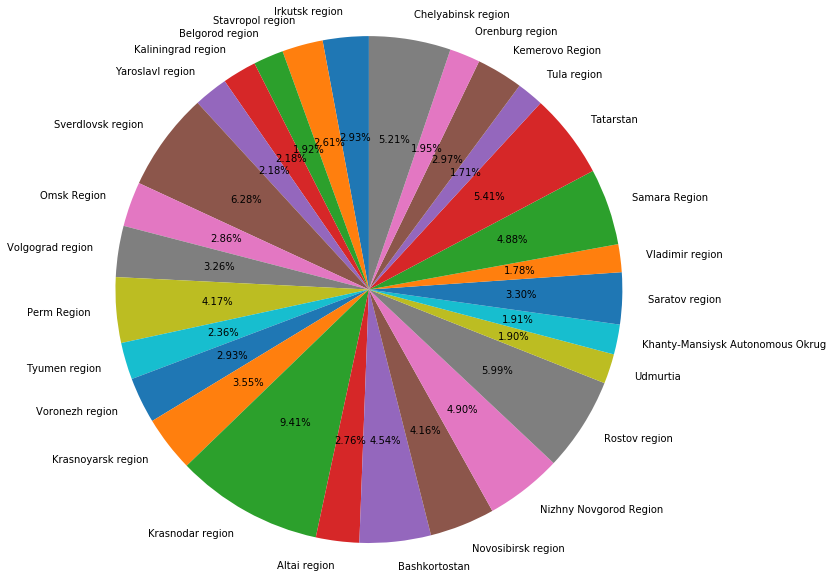

In [23]:
# Visualize train distribution
fig1, ax1 = plt.subplots(figsize=(10, 10))
ax1.pie([float(val)/len(translated_regions_train) for val in train_regions_sizes.values()], 
        labels=[lab for lab in train_regions_sizes], startangle=90, autopct='%1.2f%%')
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

In [24]:
# Compare train and test region distribution 
train_test_region = {}
for region in translated_regions:
    train_test_region[region] = [train_regions_sizes[region], test_regions_sizes[region]]
region_eval_df = pd.DataFrame.from_dict(train_test_region, orient='index')
region_eval_df.columns = ['train', 'test']
region_eval_df['train_percent'] = 100*np.divide(region_eval_df.train, float(len(translated_regions_train)))
region_eval_df['test_percent'] = 100*np.divide(region_eval_df.test, float(len(translated_regions_test)))
region_eval_df['abs_percent_diff'] = np.abs(region_eval_df.train_percent - region_eval_df.test_percent)

In [25]:
print 'Maximum percent difference in distribution between train and test:', np.amax(region_eval_df.abs_percent_diff)

Maximum percent difference in distribution between train and test: 0.7401319317258901


### Making "region" population dictionary

#### Coordinate Representation:
1 degree = 60 minutes (conversion factor)
* Longitutude:
    * East (negative)
    * West (positive)
* Latitude:
    * North (positive)
    * South (negative)

Key below: population, latitude (degrees, minutes), longitude (degrees, minutes), area (km2)

In [26]:
region_metadata = \
[[206168, 50, 55, -86, -55, 92600], [4072292, 54, 28, -56, -16, 143600], [1532526, 50, 46, -37, -27, 27100], 
 [1443693, 56, 5, -40, -37, 29000], [2610161, 49, 44, -44, -7, 113900], [2331100, 51, 3, -40, -9, 52400], 
 [2428750, 57, 22, -106, 0, 767900], [941873, 54, 48, -21, -25, 15100], [2763135, 54, 56, -87, -14, 95500],
 [5226647, 45, 22, -39, -26, 76000], [2828187, 59, 53, -91, -40, 2339700], [3310597, 56, 29, -44, -32, 76900],
 [2665911, 55, 27, -79, -33, 178200], [1977665, 56, 13, -73, -16, 139700], [2033072, 52, 8, -55, -36, 124000], 
 [2635276, 59, 14, -56, -8, 160600], [4277976, 47, 52, -41, -11, 100800], [3215532, 53, 27, -50, -27, 53600], 
 [2521892, 51, 47, -46, -44, 100200], [4297747, 58, 42, -61, -20, 194800], [2786281, 45, 3, -43, -16, 66500],
 [3786488, 55, 33, -50, -56, 68000], [1553925, 53, 55, -37, -35, 25700], [3395755, 57, 50, -69, 0, 1435200], 
 [1521420, 57, 17, -52, -45, 42100], [1532243, 62, 15, -70, -10, 534800], [3476217, 54, 32, -60, -20, 87900], 
 [1272468, 57, 52, -39, -12, 36400]]

In [27]:
region_meta_dict = {}
for i, region in enumerate(translated_regions):
    region_meta_dict[region] = region_metadata[i]

In [28]:
region_meta_df = pd.DataFrame.from_dict(region_meta_dict, orient='index')
region_meta_df.columns = ['population', 'lat_deg', 'lat_min', 'long_deg', 'long_min', 'area']
region_meta_df['latitude'] = np.round((region_meta_df.lat_deg + (region_meta_df.lat_min/60)), decimals=3)
region_meta_df['longitude'] = np.round((region_meta_df.long_deg + (region_meta_df.long_min/60)), decimals=3)
region_meta_df['density'] = np.round(np.divide(region_meta_df.population, 1.0*region_meta_df.area), decimals=3)

In [42]:
region_cols_keep = ['population', 'area', 'latitude', 'longitude', 'density']
export_region_df = region_meta_df.loc[:][region_cols_keep]
export_region_df.to_csv(scripts_path + 'region_info_df.csv', index=None)

In [43]:
export_region_df = pd.read_csv(scripts_path + 'region_info_df.csv')
export_region_df.head()

,population,area,latitude,longitude,density
0,2428750,767900,57.367,-106.000,3.163
1,2786281,66500,45.050,-43.267,41.899
2,1553925,25700,53.917,-37.583,60.464
3,3215532,53600,53.450,-50.450,59.991
4,1272468,36400,57.867,-39.200,34.958


## Exploring "city" Field:

In [30]:
# Check for nan in train dataframe
train_df.city.isnull().sum()

0

In [31]:
# Check for nan in test dataframe
test_df.city.isnull().sum()

0

In [32]:
def compare_similarity(train, test):
    train_set = list(set(train))
    test_set = list(set(test))
    intersect = np.intersect1d(train_set, test_set)
    print 'Length of train set:', len(train_set)
    print 'Length of test set:', len(test_set)
    print 'Number of common elements:', len(intersect)
    return(train_set, test_set, intersect)

In [33]:
city_train_set, city_test_set, city_intersect = compare_similarity(train_df.city.values, test_df.city.values)

Length of train set: 1733
Length of test set: 1644
Number of common elements: 1625


Many of the specific city fields cannot be translated using either Textblob or the Google Translate API. Moreover, whatever population or location information that the city name could've provided has already been accounted for by the inclusion of region data. As such, I will be leaving out the **city** field from the first-pass analysis and modeling.

## Exploring "parent_category_name" Field:

In [40]:
print 'Number of null elements for train_df:', train_df.parent_category_name.isnull().sum()
print 'Number of null elements for test_df:', test_df.parent_category_name.isnull().sum()

Number of null elements for train_df: 0
Number of null elements for test_df: 0


In [41]:
pcn_trainset, pcn_testset, pcn_intersect = compare_similarity(train_df.parent_category_name.values, 
                                                              test_df.parent_category_name.values)

Length of train set: 9
Length of test set: 9
Number of common elements: 9


In [52]:
# Get translations of parent category fields
pcn_translated = [translate_to_english(x) for x in pcn_intersect]
pprint.pprint(pcn_translated)
pcn_dictionary = {}
for i, categ in enumerate(pcn_intersect):
    pcn_dictionary[categ] = pcn_translated[i]

['Consumer electronics',
 'For business',
 'For home and cottages',
 'Animals',
 'Personal things',
 'The property',
 'Transport',
 'The services',
 'Hobbies and Recreation']


In [74]:
translated_train_pcn = [pcn_dictionary[x] for x in train_df.parent_category_name.values]
translated_test_pcn = [pcn_dictionary[x] for x in test_df.parent_category_name.values]

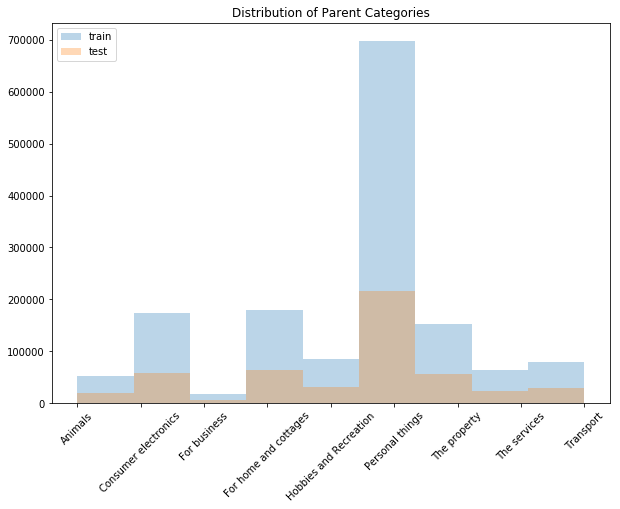

In [108]:
num_bins = len(pcn_translated)
plt.figure(figsize=(10, 7))
plt.hist(translated_train_pcn, alpha=0.3, label='train', bins=num_bins)
plt.hist(translated_test_pcn, alpha=0.3, label='test', bins=num_bins)
plt.legend(loc='upper left')
plt.title('Distribution of Parent Categories')
plt.xticks(rotation=45)
plt.show()

In [96]:
mlb = MultiLabelBinarizer()
train_pcn_onehot = mlb.fit_transform([[x] for x in translated_train_pcn])
test_pcn_onehot = mlb.fit_transform([[x] for x in translated_test_pcn])

## Exploring "category_name" Field:

In [98]:
print 'Number of null elements for train_df:', train_df.category_name.isnull().sum()
print 'Number of null elements for test_df:', test_df.category_name.isnull().sum()

Number of null elements for train_df: 0
Number of null elements for test_df: 0


In [99]:
categ_trainset, categ_testset, categ_intersect = compare_similarity(train_df.category_name.values, 
                                                                    test_df.category_name.values)

Length of train set: 47
Length of test set: 47
Number of common elements: 47


In [102]:
categs_translated = [translate_to_english(x) for x in categ_intersect]
categs_dictionary = {}
for i, categ in enumerate(categ_intersect):
    categs_dictionary[categ] = categs_translated[i]

In [103]:
translated_categs_train = [categs_dictionary[x] for x in train_df.category_name.values]
translated_categs_test = [categs_dictionary[x] for x in test_df.category_name.values]

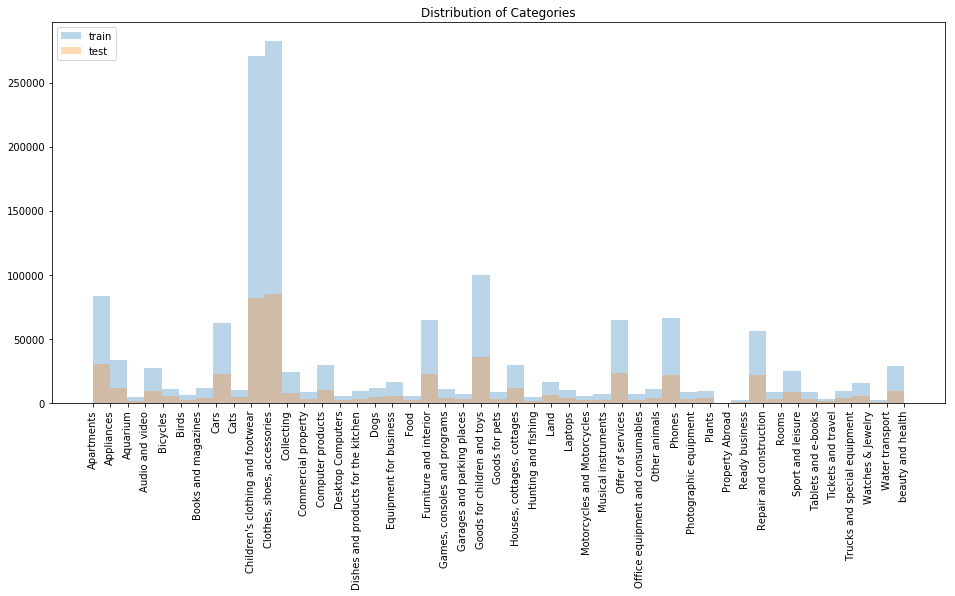

In [107]:
num_bins = len(categs_translated)
plt.figure(figsize=(16, 7))
plt.hist(translated_categs_train, alpha=0.3, label='train', bins=num_bins)
plt.hist(translated_categs_test, alpha=0.3, label='test', bins=num_bins)
plt.legend(loc='upper left')
plt.title('Distribution of Categories')
plt.xticks(rotation=90)
plt.show()

In [109]:
train_categs_onehot = mlb.fit_transform([[x] for x in translated_categs_train])
test_categs_onehot = mlb.fit_transform([[x] for x in translated_categs_test])